In [1]:
import numpy as np
import pandas as pd
import data_clean_utils
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split
import joblib

In [2]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import dagshub
dagshub.init(repo_owner='Ranjeet-Kumar60', repo_name='swiggy-delivery-time-prediction-project', mlflow=True)

Accessing as Ranjeet-Kumar60

Initialized MLflow to track repo "Ranjeet-Kumar60/swiggy-delivery-time-prediction-project"

Repository Ranjeet-Kumar60/swiggy-delivery-time-prediction-project initialized!

In [4]:
import mlflow

In [5]:
# set the tracking server

mlflow.set_tracking_uri("https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow")

In [6]:
# mlflow experiment

mlflow.set_experiment("Exp 4 - LGBM Hyperparameters Tuning")

<Experiment: artifact_location='mlflow-artifacts:/71b0d6896bf04f54a921261d6bb6984e', creation_time=1758302801940, experiment_id='4', last_update_time=1758302801940, lifecycle_stage='active', name='Exp 4 - LGBM Hyperparameters Tuning', tags={}>

In [7]:
from sklearn import set_config

set_config(transform_output="pandas")

# Load the Data

In [8]:
df = pd.read_csv("../data/raw/swiggy.csv")
df

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,0x7c09,JAPRES04DEL01,30,4.8,26.902328,75.794257,26.912328,75.804257,24-03-2022,11:35:00,11:45:00,conditions Windy,High,1,Meal,motorcycle,0,No,Metropolitian,(min) 32
45589,0xd641,AGRRES16DEL01,21,4.6,0.000000,0.000000,0.070000,0.070000,16-02-2022,19:55:00,20:10:00,conditions Windy,Jam,0,Buffet,motorcycle,1,No,Metropolitian,(min) 36
45590,0x4f8d,CHENRES08DEL03,30,4.9,13.022394,80.242439,13.052394,80.272439,11-03-2022,23:50:00,00:05:00,conditions Cloudy,Low,1,Drinks,scooter,0,No,Metropolitian,(min) 16
45591,0x5eee,COIMBRES11DEL01,20,4.7,11.001753,76.986241,11.041753,77.026241,07-03-2022,13:35:00,13:40:00,conditions Cloudy,High,0,Snack,motorcycle,1,No,Metropolitian,(min) 26


# Clean Data

In [9]:
swiggy_cleaned=data_clean_utils.perform_data_cleaning(df)

In [10]:
swiggy_cleaned

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day,distance,distance_type
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,INDO,19,3,saturday,1,15.0,11.0,morning,3.025149,short
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,BANG,25,3,friday,0,5.0,19.0,evening,20.183530,very_long
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,BANG,19,3,saturday,1,15.0,8.0,morning,1.552758,short
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,COIMB,5,4,tuesday,0,10.0,18.0,evening,7.790401,medium
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,CHEN,26,3,saturday,1,15.0,13.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,windy,high,...,JAP,24,3,thursday,0,10.0,11.0,morning,1.489846,short
45589,AGRRES16DEL01,21.0,4.6,NaN,NaN,NaN,NaN,2022-02-16,windy,jam,...,AGR,16,2,wednesday,0,15.0,19.0,evening,NaN,NaN
45590,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,cloudy,low,...,CHEN,11,3,friday,0,15.0,23.0,night,4.657195,short
45591,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,cloudy,high,...,COIMB,7,3,monday,0,5.0,13.0,afternoon,6.232393,medium


In [11]:
swiggy_cleaned.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'order_day', 'order_month',
       'order_day_of_week', 'is_weekend', 'pickup_time_minutes',
       'order_time_hour', 'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [12]:
# drop columns not required for model input

columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day",
                    "city_name",
                    "order_day_of_week",
                    "order_month"]

swiggy_cleaned.drop(columns=columns_to_drop, inplace=True)

swiggy_cleaned

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
45589,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,36,0,15.0,evening,NaN,NaN
45590,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,15.0,night,4.657195,short
45591,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


In [13]:
# check for missing values

swiggy_cleaned.isna().sum()

age                    1854
ratings                1908
weather                 525
traffic                 510
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     993
festival                228
city_type              1198
time_taken                0
is_weekend                0
pickup_time_minutes    1640
order_time_of_day      2070
distance               3630
distance_type          3630
dtype: int64

In [14]:
# check for duplicates

swiggy_cleaned.duplicated().sum()

np.int64(0)

<Axes: >

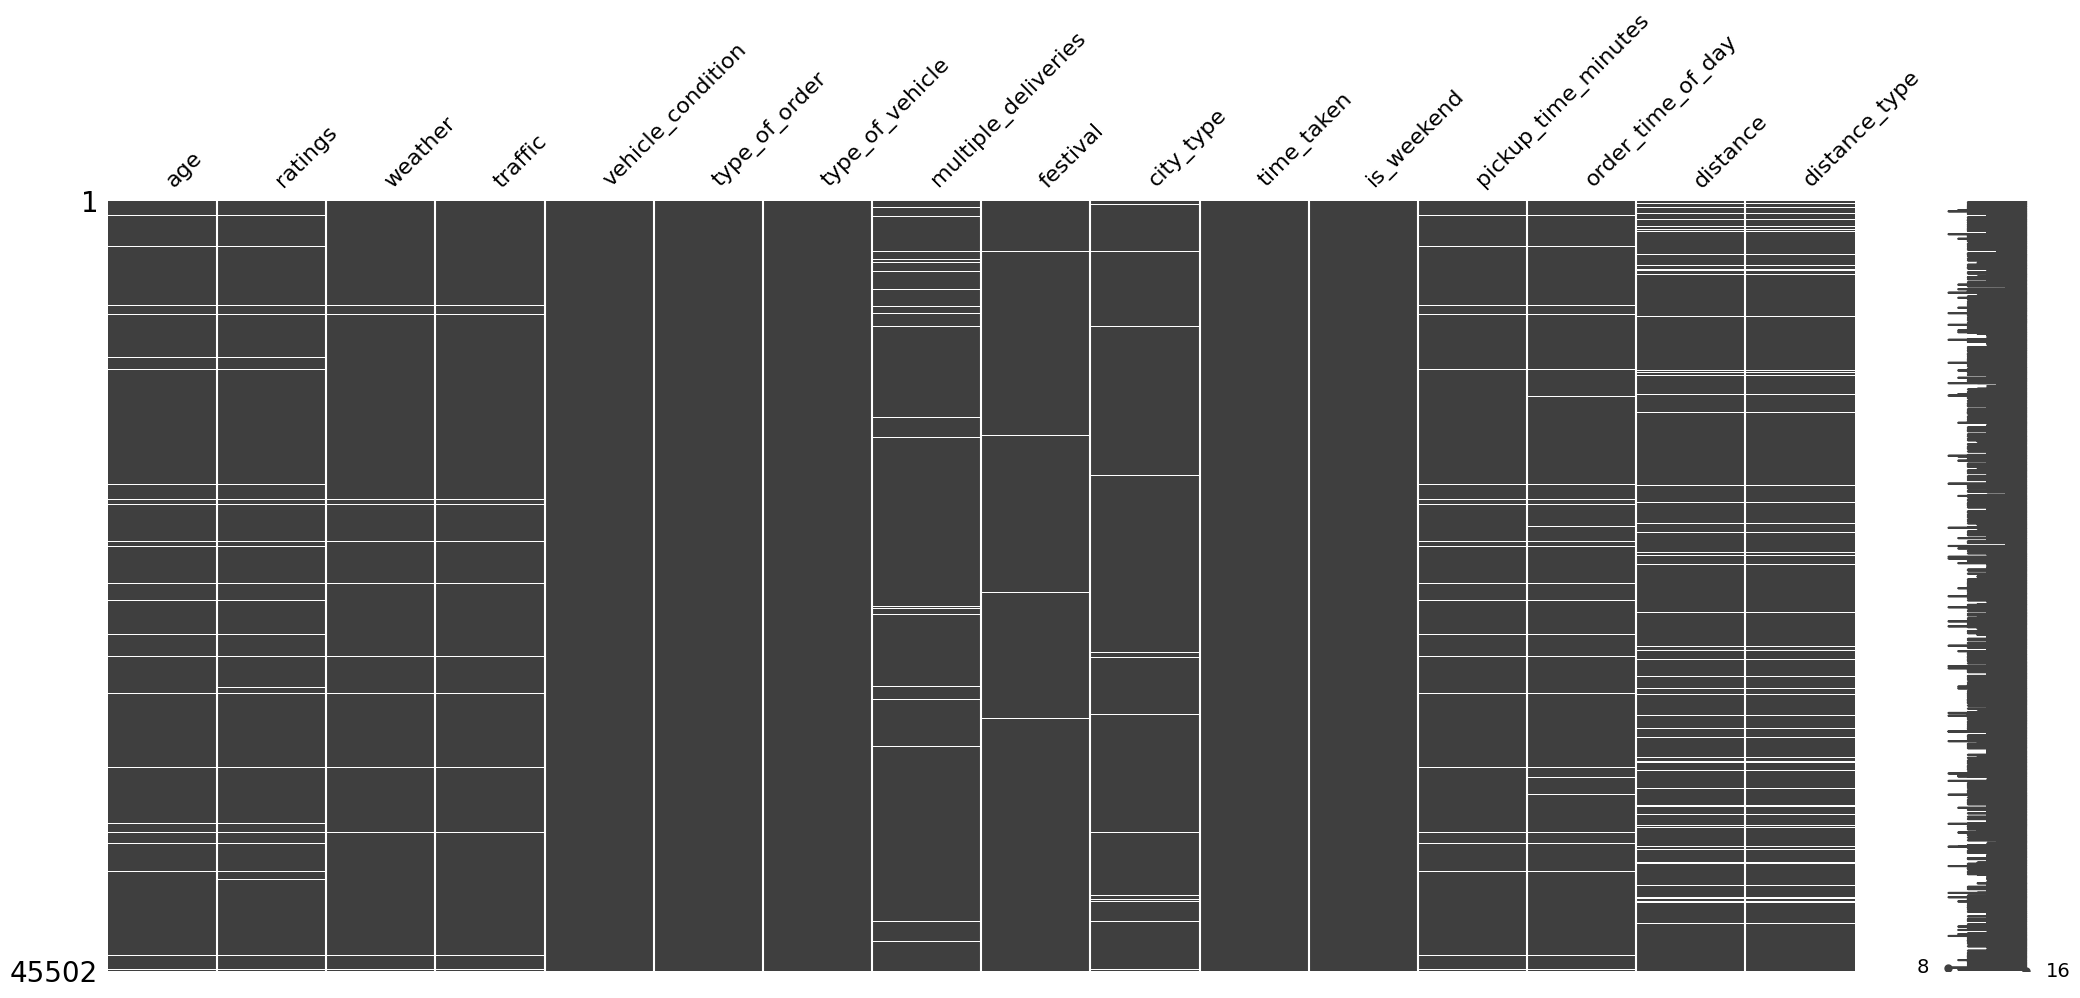

In [15]:
import missingno as msno

msno.matrix(swiggy_cleaned)

In [16]:
# columns that have missing values

missing_cols = (
                    swiggy_cleaned
                    .isna()
                    .any(axis=0)
                    .loc[lambda x: x]
                    .index
                )

missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

# Drop Missing values

In [17]:
temp_df = swiggy_cleaned.copy().dropna()

In [18]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45587,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,0,10.0,night,16.600272,very_long
45588,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,morning,1.489846,short
45590,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,15.0,night,4.657195,short
45591,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,afternoon,6.232393,medium


In [19]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [20]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (30156, 15)
The shape of test data is (7539, 15)


In [21]:
# missing values in train data

X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [22]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [23]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [24]:
# percentage of rows in data having missing values

(
    X_train
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)


np.float64(0.0)

# Pre-Processing Pipeline

In [25]:
num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather',
                    'type_of_order',
                    'type_of_vehicle',
                    "festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [26]:
nominal_cat_cols

['weather',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'is_weekend',
 'order_time_of_day']

In [27]:
X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [28]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [29]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [30]:
# unique categories the ordinal columns

for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'medium' 'high' 'low']
distance_type ['medium', 'short', 'long', 'very_long']
Categories (4, object): ['short' < 'medium' < 'long' < 'very_long']


In [31]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",
                                     sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order],
                                      encoded_missing_value=-999,
                                      handle_unknown="use_encoded_value",
                                      unknown_value=-1), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)


preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'is_weekend',
                                  'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [32]:
# build the pipeline

processing_pipeline = Pipeline(steps=[
                                ("preprocess",preprocessor)
                            ])

processing_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('scale', MinMaxScaler(),
                                                  ['age', 'ratings',
                                                   'pickup_time_minutes',
                                                   'distance']),
                                                 ('nominal_encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['weather', 'type_of_order',
                                                   'type_of_vehicle',
                                                   'festival', 'city_type',
                                                   'is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False))])

In [33]:
# do data preprocessing

X_train_trans = processing_pipeline.fit_transform(X_train)

X_test_trans = processing_pipeline.transform(X_test)

In [34]:
X_train_trans

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_semi-urban,city_type_urban,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,vehicle_condition,multiple_deliveries
8720,0.473684,0.56,1.0,0.404165,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0,2.0
25245,1.000000,0.76,0.0,0.154044,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1.0
34118,0.473684,0.80,0.5,0.002461,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1,0.0
26036,1.000000,0.92,1.0,0.460411,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0,1.0
37194,0.526316,0.76,0.5,0.243676,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20275,0.578947,0.92,0.5,0.451895,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,0,0.0
7601,0.052632,1.00,1.0,0.612270,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1,1.0
13632,0.526316,0.92,0.0,0.322877,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,0.0
1045,0.947368,0.96,0.5,0.004486,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1.0


In [35]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [36]:
from lightgbm import LGBMRegressor
import optuna

c:\Users\Admin\anaconda3\envs\swiggy_project_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor

In [38]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators",10,200),
            "max_depth": trial.suggest_int("max_depth",1,40),
            "learning_rate": trial.suggest_float("learning_rate",0.1,0.8),
            "subsample": trial.suggest_float("subsample",0.5,1),
            "min_child_weight": trial.suggest_int("min_child_weight",5,20),
            "min_split_gain": trial.suggest_float("min_split_gain",0,10),
            "reg_lambda": trial.suggest_float("reg_lambda",0,100),
            "random_state": 42,
            "n_jobs": -1,
        }

        # log model parameters
        mlflow.log_params(params)

        xgb_reg = LGBMRegressor(**params)
        model = TransformedTargetRegressor(regressor=xgb_reg,transformer=pt)

        # train the model
        model.fit(X_train_trans,y_train)

        # get the predictions
        y_pred_train = model.predict(X_train_trans)
        y_pred_test = model.predict(X_test_trans)


        # perform cross validation
        cv_score = cross_val_score(model,
                                X_train_trans,
                                y_train,
                                cv=5,
                                scoring="neg_mean_absolute_error",
                                n_jobs=-1)

        # mean score
        mean_score = -(cv_score.mean())
        # log avg cross val error
        mlflow.log_metric("cross_val_error",mean_score)

        return mean_score

In [39]:
# create optuna study
study = optuna.create_study(direction="minimize")

with mlflow.start_run(run_name="best_model"):
    # optimize the objective function
    study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)

    # log the best parameters
    mlflow.log_params(study.best_params)

    # log the best score
    mlflow.log_metric("best_score", study.best_value)

    # train the model on best parameters
    best_lgbm = LGBMRegressor(**study.best_params)
    best_lgbm.fit(X_train_trans, y_train_pt.values.ravel())

    # get the predictions
    y_pred_train = best_lgbm.predict(X_train_trans)
    y_pred_test = best_lgbm.predict(X_test_trans)

    # get the actual predictions values
    y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1, 1))
    y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1, 1))

    # perform cross validation
    model = TransformedTargetRegressor(regressor=best_lgbm,
                                       transformer=pt)

    scores = cross_val_score(model,
                             X_train_trans,
                             y_train,
                             scoring="neg_mean_absolute_error",
                             cv=5, n_jobs=-1)

    # log metrics
    mlflow.log_metric("training_error", mean_absolute_error(y_train, y_pred_train_org))
    mlflow.log_metric("test_error", mean_absolute_error(y_test, y_pred_test_org))
    mlflow.log_metric("training_r2", r2_score(y_train, y_pred_train_org))
    mlflow.log_metric("test_r2", r2_score(y_test, y_pred_test_org))
    mlflow.log_metric("cross_val", -scores.mean())

    # ---- FIXED PART ----
    # save model locally
    model_path = "best_lgbm.pkl"
    joblib.dump(best_lgbm, model_path)

    # log as artifact (works with DagsHub MLflow)
    mlflow.log_artifact(model_path, artifact_path="model")

[I 2025-09-19 10:29:40,758] A new study created in memory with name: no-name-54e3e1fd-c0dd-4d2f-83e7-6b5974bd88a1
  0%|          | 0/50 [00:00<?, ?it/s]

🏃 View run adaptable-rook-519 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/30a862e7286b4f0c936d12217557b92a
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run luxuriant-pug-855 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/ae46c534817e4173bebc099baece7514
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run omniscient-toad-327 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/f1552cf12ed34dad8645ae7f62b5bc42
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run youthful-asp-644 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experim

Best trial: 0. Best value: 3.73211:   2%|▏         | 1/50 [00:55<45:30, 55.73s/it]

[I 2025-09-19 10:30:37,579] Trial 0 finished with value: 3.7321106281217 and parameters: {'n_estimators': 149, 'max_depth': 17, 'learning_rate': 0.1875336307228519, 'subsample': 0.8811070255306983, 'min_child_weight': 5, 'min_split_gain': 8.769899298621858, 'reg_lambda': 43.35846835270784}. Best is trial 0 with value: 3.7321106281217.


Best trial: 0. Best value: 3.73211:   4%|▍         | 2/50 [00:56<18:50, 23.56s/it]

[I 2025-09-19 10:30:38,611] Trial 5 finished with value: 4.3048873581602205 and parameters: {'n_estimators': 163, 'max_depth': 1, 'learning_rate': 0.4524432854349979, 'subsample': 0.9821146955781498, 'min_child_weight': 7, 'min_split_gain': 8.858613453828706, 'reg_lambda': 63.35721471393212}. Best is trial 0 with value: 3.7321106281217.
🏃 View run charming-gnat-759 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/0294d36d766d4b9e8c71bbbe68ee3002
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run colorful-koi-420 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/41f578388f9d446db962fe4eab99488c
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 0. Best value: 3.73211:   6%|▌         | 3/50 [00:59<11:09, 14.24s/it]

[I 2025-09-19 10:30:41,757] Trial 2 finished with value: 3.7462394780458874 and parameters: {'n_estimators': 115, 'max_depth': 37, 'learning_rate': 0.26784975300144787, 'subsample': 0.8609278321571137, 'min_child_weight': 12, 'min_split_gain': 9.086415170253542, 'reg_lambda': 39.93774290896641}. Best is trial 0 with value: 3.7321106281217.
🏃 View run charming-fawn-977 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/bd500f8054094a4d99948cf81e0d780b
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run likeable-koi-783 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/ea1b525906644a9e98bee3f9bd447995
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 4. Best value: 3.50591:   8%|▊         | 4/50 [01:02<07:26,  9.71s/it]

[I 2025-09-19 10:30:44,522] Trial 4 finished with value: 3.5059095094147295 and parameters: {'n_estimators': 111, 'max_depth': 37, 'learning_rate': 0.2775871985734035, 'subsample': 0.548226394335773, 'min_child_weight': 14, 'min_split_gain': 1.952321362593784, 'reg_lambda': 42.26398912338334}. Best is trial 4 with value: 3.5059095094147295.


Best trial: 4. Best value: 3.50591:  10%|█         | 5/50 [01:03<04:55,  6.58s/it]

[I 2025-09-19 10:30:45,534] Trial 6 finished with value: 3.758575384164218 and parameters: {'n_estimators': 27, 'max_depth': 9, 'learning_rate': 0.49225989644923285, 'subsample': 0.9049813557600279, 'min_child_weight': 11, 'min_split_gain': 8.320650558189687, 'reg_lambda': 12.842704247360647}. Best is trial 4 with value: 3.5059095094147295.
🏃 View run rumbling-lynx-268 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/fabe3fc111504720a1571184b6cf02c9
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 4. Best value: 3.50591:  12%|█▏        | 6/50 [01:07<04:10,  5.70s/it]

[I 2025-09-19 10:30:49,540] Trial 11 finished with value: 3.585718791126098 and parameters: {'n_estimators': 195, 'max_depth': 32, 'learning_rate': 0.6060362150734886, 'subsample': 0.7749170113142394, 'min_child_weight': 18, 'min_split_gain': 2.6867026881153624, 'reg_lambda': 64.27717863606375}. Best is trial 4 with value: 3.5059095094147295.


Best trial: 1. Best value: 3.22841:  14%|█▍        | 7/50 [01:09<03:03,  4.27s/it]

[I 2025-09-19 10:30:50,868] Trial 1 finished with value: 3.2284107776258906 and parameters: {'n_estimators': 188, 'max_depth': 16, 'learning_rate': 0.23342208004307147, 'subsample': 0.7496174345149004, 'min_child_weight': 13, 'min_split_gain': 0.18628459953323961, 'reg_lambda': 42.05495482272581}. Best is trial 1 with value: 3.2284107776258906.


Best trial: 1. Best value: 3.22841:  16%|█▌        | 8/50 [01:10<02:25,  3.47s/it]

[I 2025-09-19 10:30:52,601] Trial 8 finished with value: 3.801688360055862 and parameters: {'n_estimators': 110, 'max_depth': 31, 'learning_rate': 0.7702373693154999, 'subsample': 0.9478694934438752, 'min_child_weight': 12, 'min_split_gain': 7.7540655997512165, 'reg_lambda': 76.80604332204318}. Best is trial 1 with value: 3.2284107776258906.


Best trial: 1. Best value: 3.22841:  18%|█▊        | 9/50 [01:14<02:28,  3.63s/it]

[I 2025-09-19 10:30:56,601] Trial 9 finished with value: 3.817075562411071 and parameters: {'n_estimators': 182, 'max_depth': 35, 'learning_rate': 0.7662701636850657, 'subsample': 0.6892316692177982, 'min_child_weight': 8, 'min_split_gain': 8.693018381047342, 'reg_lambda': 63.29418601414572}. Best is trial 1 with value: 3.2284107776258906.
🏃 View run marvelous-panda-401 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/1f4eaeac3dd34153b00b7e8937e14641
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 1. Best value: 3.22841:  20%|██        | 10/50 [01:25<03:54,  5.86s/it]

[I 2025-09-19 10:31:07,435] Trial 10 finished with value: 3.6175084354182885 and parameters: {'n_estimators': 155, 'max_depth': 32, 'learning_rate': 0.30262313370751737, 'subsample': 0.6731689832433359, 'min_child_weight': 19, 'min_split_gain': 4.098418894934065, 'reg_lambda': 22.27706740114651}. Best is trial 1 with value: 3.2284107776258906.


Best trial: 1. Best value: 3.22841:  22%|██▏       | 11/50 [01:30<03:38,  5.60s/it]

[I 2025-09-19 10:31:12,481] Trial 7 finished with value: 3.3456279778429376 and parameters: {'n_estimators': 175, 'max_depth': 19, 'learning_rate': 0.1294493513762964, 'subsample': 0.8849228175795277, 'min_child_weight': 20, 'min_split_gain': 0.8459994680984606, 'reg_lambda': 7.214079753889536}. Best is trial 1 with value: 3.2284107776258906.
🏃 View run legendary-trout-416 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/9c5383411396468a860f134d3276a6da
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run bold-whale-120 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/9b0266980b2d46099323845feb0975eb
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run nervous-crow-824 at: https://dagshub.com/Ranjeet-Kumar60/swiggy

Best trial: 1. Best value: 3.22841:  24%|██▍       | 12/50 [02:08<09:49, 15.52s/it]

[I 2025-09-19 10:31:50,673] Trial 13 finished with value: 3.7515791616525282 and parameters: {'n_estimators': 106, 'max_depth': 40, 'learning_rate': 0.5717692252461652, 'subsample': 0.9919822252915258, 'min_child_weight': 19, 'min_split_gain': 9.492812112051576, 'reg_lambda': 65.3965611828246}. Best is trial 1 with value: 3.2284107776258906.
🏃 View run omniscient-gnu-268 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/afc30085ff954313b4e2a65863f04151
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run illustrious-bass-60 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/c839f30e6a464841986085f9571622a5
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 1. Best value: 3.22841:  26%|██▌       | 13/50 [02:12<07:26, 12.06s/it]

[I 2025-09-19 10:31:54,767] Trial 12 finished with value: 3.7351594882619366 and parameters: {'n_estimators': 81, 'max_depth': 33, 'learning_rate': 0.11825717583402565, 'subsample': 0.8174335224542184, 'min_child_weight': 8, 'min_split_gain': 7.019331902355183, 'reg_lambda': 89.21491487588752}. Best is trial 1 with value: 3.2284107776258906.
🏃 View run stylish-frog-275 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/503071c9d30d45ab85f63f1867de4561
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 15. Best value: 3.20118:  28%|██▊       | 14/50 [02:15<05:34,  9.28s/it]

[I 2025-09-19 10:31:57,634] Trial 15 finished with value: 3.2011820206155726 and parameters: {'n_estimators': 123, 'max_depth': 15, 'learning_rate': 0.24074734589178723, 'subsample': 0.822004671882997, 'min_child_weight': 14, 'min_split_gain': 0.22077563567689418, 'reg_lambda': 1.44147272448244}. Best is trial 15 with value: 3.2011820206155726.


Best trial: 15. Best value: 3.20118:  30%|███       | 15/50 [02:16<03:57,  6.79s/it]

[I 2025-09-19 10:31:58,659] Trial 14 finished with value: 3.77162019962158 and parameters: {'n_estimators': 176, 'max_depth': 40, 'learning_rate': 0.633451501615435, 'subsample': 0.5366333769973975, 'min_child_weight': 18, 'min_split_gain': 7.474282874512161, 'reg_lambda': 3.5359147048161343}. Best is trial 15 with value: 3.2011820206155726.
🏃 View run adaptable-bird-163 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/8a0fdbb66f6f485388e30432b93fe74e
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 15. Best value: 3.20118:  32%|███▏      | 16/50 [02:21<03:31,  6.23s/it]

[I 2025-09-19 10:32:03,574] Trial 18 finished with value: 3.2966741575908407 and parameters: {'n_estimators': 138, 'max_depth': 30, 'learning_rate': 0.518065874679286, 'subsample': 0.5327166236968669, 'min_child_weight': 10, 'min_split_gain': 0.15656268989153288, 'reg_lambda': 65.84429780692474}. Best is trial 15 with value: 3.2011820206155726.
[I 2025-09-19 10:32:03,578] Trial 19 finished with value: 3.6795454432876413 and parameters: {'n_estimators': 146, 'max_depth': 10, 'learning_rate': 0.6369169653705666, 'subsample': 0.942372090508818, 'min_child_weight': 7, 'min_split_gain': 4.019950749803502, 'reg_lambda': 41.6214445293268}. Best is trial 15 with value: 3.2011820206155726.


Best trial: 15. Best value: 3.20118:  36%|███▌      | 18/50 [02:24<02:09,  4.06s/it]

[I 2025-09-19 10:32:06,648] Trial 17 finished with value: 3.7956658046427405 and parameters: {'n_estimators': 24, 'max_depth': 31, 'learning_rate': 0.12138734377814399, 'subsample': 0.822941269506944, 'min_child_weight': 7, 'min_split_gain': 8.018994136832928, 'reg_lambda': 33.734105416719075}. Best is trial 15 with value: 3.2011820206155726.


Best trial: 15. Best value: 3.20118:  38%|███▊      | 19/50 [02:29<02:12,  4.26s/it]

[I 2025-09-19 10:32:11,518] Trial 20 finished with value: 3.27776595920801 and parameters: {'n_estimators': 57, 'max_depth': 29, 'learning_rate': 0.5492892956621016, 'subsample': 0.7497894101827777, 'min_child_weight': 11, 'min_split_gain': 0.23277367087037648, 'reg_lambda': 21.236776319232774}. Best is trial 15 with value: 3.2011820206155726.
🏃 View run enchanting-stork-802 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/103886eb655b4745aa0995905d71e8bc
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run funny-owl-162 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/42996979108440918e86d3cb9646782b
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 21. Best value: 3.13843:  40%|████      | 20/50 [02:43<03:24,  6.80s/it]

[I 2025-09-19 10:32:25,485] Trial 21 finished with value: 3.138432718419238 and parameters: {'n_estimators': 54, 'max_depth': 21, 'learning_rate': 0.10045076208349206, 'subsample': 0.7910179518697267, 'min_child_weight': 16, 'min_split_gain': 0.04405242736408824, 'reg_lambda': 2.1513555963199087}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843:  42%|████▏     | 21/50 [02:46<02:47,  5.79s/it]

[I 2025-09-19 10:32:28,562] Trial 16 finished with value: 3.4894026091844665 and parameters: {'n_estimators': 78, 'max_depth': 17, 'learning_rate': 0.1888714147765908, 'subsample': 0.6282008917336723, 'min_child_weight': 19, 'min_split_gain': 1.3027416847219009, 'reg_lambda': 96.2229098814699}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843:  44%|████▍     | 22/50 [02:48<02:14,  4.80s/it]

[I 2025-09-19 10:32:30,807] Trial 22 finished with value: 3.1530485494387035 and parameters: {'n_estimators': 46, 'max_depth': 22, 'learning_rate': 0.1050273667665137, 'subsample': 0.7907028367613821, 'min_child_weight': 16, 'min_split_gain': 0.01275748699756607, 'reg_lambda': 5.368430167921119}. Best is trial 21 with value: 3.138432718419238.
🏃 View run welcoming-stoat-783 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/d7021bfc9093485eb1c726b3ce736f0f
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run thundering-horse-133 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/9bce7e47e1564515b5d0b27347969240
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run flawless-deer-153 at: https://dagshub.com/Ranjeet-Kumar6

Best trial: 21. Best value: 3.13843:  46%|████▌     | 23/50 [04:45<16:32, 36.75s/it]

[I 2025-09-19 10:34:27,434] Trial 24 finished with value: 3.5135163845643858 and parameters: {'n_estimators': 71, 'max_depth': 24, 'learning_rate': 0.3306625138048701, 'subsample': 0.6943815099469747, 'min_child_weight': 15, 'min_split_gain': 1.6940425859331976, 'reg_lambda': 23.830546659711437}. Best is trial 21 with value: 3.138432718419238.
🏃 View run serious-wolf-109 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/e289fd46d1a9403c928c7a9bd2618aee
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 21. Best value: 3.13843:  48%|████▊     | 24/50 [04:48<11:42, 27.02s/it]

[I 2025-09-19 10:34:30,614] Trial 26 finished with value: 3.515930995594881 and parameters: {'n_estimators': 76, 'max_depth': 25, 'learning_rate': 0.369345705389773, 'subsample': 0.7059738053247182, 'min_child_weight': 15, 'min_split_gain': 1.5953291746284448, 'reg_lambda': 21.776585626324284}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843:  50%|█████     | 25/50 [04:50<08:11, 19.67s/it]

[I 2025-09-19 10:34:32,547] Trial 29 finished with value: 3.674668277270571 and parameters: {'n_estimators': 80, 'max_depth': 25, 'learning_rate': 0.3634561526436354, 'subsample': 0.6442012634039228, 'min_child_weight': 15, 'min_split_gain': 6.015463619969885, 'reg_lambda': 98.21773936444487}. Best is trial 21 with value: 3.138432718419238.
🏃 View run gentle-loon-158 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/3fac37c4025649d2b0de73013fe57a36
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 21. Best value: 3.13843:  52%|█████▏    | 26/50 [04:54<06:01, 15.06s/it]

[I 2025-09-19 10:34:36,573] Trial 3 finished with value: 3.723281787394744 and parameters: {'n_estimators': 184, 'max_depth': 11, 'learning_rate': 0.7868144986468796, 'subsample': 0.6595002663090894, 'min_child_weight': 9, 'min_split_gain': 5.203076986902163, 'reg_lambda': 13.841302434672576}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843:  54%|█████▍    | 27/50 [04:57<04:22, 11.43s/it]

[I 2025-09-19 10:34:39,386] Trial 27 finished with value: 3.6816558889684443 and parameters: {'n_estimators': 75, 'max_depth': 24, 'learning_rate': 0.3672490478351833, 'subsample': 0.6359433284632569, 'min_child_weight': 15, 'min_split_gain': 5.8341011887283445, 'reg_lambda': 25.369041398774268}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843:  56%|█████▌    | 28/50 [05:01<03:23,  9.25s/it]

[I 2025-09-19 10:34:43,485] Trial 30 finished with value: 3.684875542241668 and parameters: {'n_estimators': 127, 'max_depth': 24, 'learning_rate': 0.3416382157158658, 'subsample': 0.6257414751189734, 'min_child_weight': 15, 'min_split_gain': 5.909785535693484, 'reg_lambda': 96.34969699889271}. Best is trial 21 with value: 3.138432718419238.
🏃 View run unique-ant-525 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/77fc498052d440c7aa273f50f1f39ecc
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run abundant-gnu-885 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/28dcf42a801640358a548f9b945d3716
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 21. Best value: 3.13843:  58%|█████▊    | 29/50 [05:19<04:09, 11.87s/it]

[I 2025-09-19 10:35:01,533] Trial 25 finished with value: 3.5265175075920183 and parameters: {'n_estimators': 73, 'max_depth': 24, 'learning_rate': 0.33614986173730554, 'subsample': 0.7066724075188322, 'min_child_weight': 15, 'min_split_gain': 2.1985805267855394, 'reg_lambda': 22.259641371129806}. Best is trial 21 with value: 3.138432718419238.
🏃 View run thundering-gnat-571 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/f2a517fc169546dbb5986f87fafc2fb6
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run defiant-dove-789 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/83de5c0dfd6c45bea8261ed18fbbeb31
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 21. Best value: 3.13843:  60%|██████    | 30/50 [05:28<03:40, 11.00s/it]

[I 2025-09-19 10:35:10,503] Trial 28 finished with value: 3.4848467450992766 and parameters: {'n_estimators': 80, 'max_depth': 24, 'learning_rate': 0.36266253053029285, 'subsample': 0.6539757493580208, 'min_child_weight': 15, 'min_split_gain': 1.7889557778670757, 'reg_lambda': 23.77954127761363}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843:  62%|██████▏   | 31/50 [05:31<02:43,  8.58s/it]

[I 2025-09-19 10:35:13,415] Trial 33 finished with value: 3.537977369988181 and parameters: {'n_estimators': 42, 'max_depth': 24, 'learning_rate': 0.36303868575228143, 'subsample': 0.8055843073948986, 'min_child_weight': 15, 'min_split_gain': 2.212620759665537, 'reg_lambda': 16.827453851785375}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843:  64%|██████▍   | 32/50 [05:38<02:26,  8.16s/it]

[I 2025-09-19 10:35:20,588] Trial 32 finished with value: 3.5353491261923 and parameters: {'n_estimators': 48, 'max_depth': 24, 'learning_rate': 0.3907338158746808, 'subsample': 0.7945471816937775, 'min_child_weight': 15, 'min_split_gain': 2.350070136109122, 'reg_lambda': 16.522848149787507}. Best is trial 21 with value: 3.138432718419238.
🏃 View run respected-foal-860 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/1d7cce5e379f4252a10d2f5a0c4b0f76
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run sneaky-seal-451 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/57cec5973c62423cb5fa39edb90672bc
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run unruly-grub-22 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-deli

Best trial: 21. Best value: 3.13843:  66%|██████▌   | 33/50 [05:56<03:07, 11.05s/it]

[I 2025-09-19 10:35:38,399] Trial 31 finished with value: 3.497603384517658 and parameters: {'n_estimators': 45, 'max_depth': 25, 'learning_rate': 0.3451910039810137, 'subsample': 0.8015515888780544, 'min_child_weight': 15, 'min_split_gain': 2.5555352518148338, 'reg_lambda': 0.9382228544079467}. Best is trial 21 with value: 3.138432718419238.
🏃 View run bittersweet-mare-987 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/aaf92c202b564dd58805616345d08260
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 21. Best value: 3.13843:  68%|██████▊   | 34/50 [06:00<02:24,  9.03s/it]

[I 2025-09-19 10:35:42,703] Trial 34 finished with value: 3.4796210895245125 and parameters: {'n_estimators': 45, 'max_depth': 13, 'learning_rate': 0.18034329276048755, 'subsample': 0.8310703481638259, 'min_child_weight': 17, 'min_split_gain': 2.742721589626208, 'reg_lambda': 0.36230774838551927}. Best is trial 21 with value: 3.138432718419238.
🏃 View run persistent-croc-309 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/6ac2a37f70cd4f159bb8d2f8e0cef315
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 21. Best value: 3.13843:  70%|███████   | 35/50 [06:04<01:52,  7.49s/it]

[I 2025-09-19 10:35:46,599] Trial 35 finished with value: 3.476474086240768 and parameters: {'n_estimators': 45, 'max_depth': 13, 'learning_rate': 0.1889096757638183, 'subsample': 0.8137308375793402, 'min_child_weight': 17, 'min_split_gain': 2.518242069536935, 'reg_lambda': 2.837725180467233}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843:  72%|███████▏  | 36/50 [06:05<01:16,  5.49s/it]

[I 2025-09-19 10:35:47,421] Trial 37 finished with value: 3.51318554619966 and parameters: {'n_estimators': 40, 'max_depth': 13, 'learning_rate': 0.19321252945589978, 'subsample': 0.794371739108528, 'min_child_weight': 17, 'min_split_gain': 2.9119548632616423, 'reg_lambda': 2.4011336710630786}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843:  74%|███████▍  | 37/50 [06:07<00:57,  4.45s/it]

[I 2025-09-19 10:35:49,434] Trial 36 finished with value: 3.4967218061395116 and parameters: {'n_estimators': 50, 'max_depth': 13, 'learning_rate': 0.18218499053028164, 'subsample': 0.8062229917144621, 'min_child_weight': 17, 'min_split_gain': 2.481216082744562, 'reg_lambda': 2.1264672991240383}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843:  76%|███████▌  | 38/50 [06:13<00:59,  4.92s/it]

[I 2025-09-19 10:35:55,465] Trial 38 finished with value: 3.778429433820129 and parameters: {'n_estimators': 11, 'max_depth': 13, 'learning_rate': 0.1701447614201273, 'subsample': 0.8015021253668926, 'min_child_weight': 17, 'min_split_gain': 2.697817539449407, 'reg_lambda': 1.4112909137693137}. Best is trial 21 with value: 3.138432718419238.
🏃 View run legendary-hound-439 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/47cb83c52be74d5488579b8ce2432790
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run languid-sow-29 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/3a7e034b22c84e81b0a98df0b91c99fe
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 21. Best value: 3.13843:  78%|███████▊  | 39/50 [06:29<01:30,  8.25s/it]

[I 2025-09-19 10:36:11,480] Trial 40 finished with value: 3.4837124903322945 and parameters: {'n_estimators': 36, 'max_depth': 14, 'learning_rate': 0.17765437349002602, 'subsample': 0.7979825937846035, 'min_child_weight': 17, 'min_split_gain': 2.7127143668333553, 'reg_lambda': 0.7251249589006941}. Best is trial 21 with value: 3.138432718419238.
🏃 View run treasured-slug-178 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/ab546ec759fc48f28932b4941d352411
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 21. Best value: 3.13843:  80%|████████  | 40/50 [06:33<01:09,  6.97s/it]

[I 2025-09-19 10:36:15,471] Trial 39 finished with value: 3.5055190506756375 and parameters: {'n_estimators': 46, 'max_depth': 13, 'learning_rate': 0.1868130234778813, 'subsample': 0.7934963284362404, 'min_child_weight': 17, 'min_split_gain': 2.6126133632700785, 'reg_lambda': 2.025563118687968}. Best is trial 21 with value: 3.138432718419238.
🏃 View run defiant-flea-218 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/97af12e2f23946619156eeb3fc4e9f38
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 21. Best value: 3.13843:  82%|████████▏ | 41/50 [06:40<01:02,  6.99s/it]

[I 2025-09-19 10:36:22,485] Trial 23 finished with value: 3.308065626547821 and parameters: {'n_estimators': 67, 'max_depth': 25, 'learning_rate': 0.3500164093754858, 'subsample': 0.7042636154092572, 'min_child_weight': 16, 'min_split_gain': 0.43440438190897346, 'reg_lambda': 25.863450933781724}. Best is trial 21 with value: 3.138432718419238.
🏃 View run trusting-shark-151 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/3519879502724dadbb88875b740654b4
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 21. Best value: 3.13843:  84%|████████▍ | 42/50 [06:47<00:56,  7.03s/it]

[I 2025-09-19 10:36:29,605] Trial 43 finished with value: 3.310282215168416 and parameters: {'n_estimators': 40, 'max_depth': 15, 'learning_rate': 0.20979967657059095, 'subsample': 0.7416484677548211, 'min_child_weight': 17, 'min_split_gain': 0.679209164143588, 'reg_lambda': 2.8796065885279014}. Best is trial 21 with value: 3.138432718419238.
🏃 View run resilient-shark-212 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/63246124ca5a4f838d7187197cbc815c
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 21. Best value: 3.13843:  86%|████████▌ | 43/50 [06:52<00:45,  6.45s/it]

[I 2025-09-19 10:36:34,716] Trial 41 finished with value: 3.317112222203625 and parameters: {'n_estimators': 36, 'max_depth': 15, 'learning_rate': 0.19827468483563945, 'subsample': 0.7426233908393778, 'min_child_weight': 17, 'min_split_gain': 0.8955131521032061, 'reg_lambda': 0.964857104914608}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843:  88%|████████▊ | 44/50 [06:56<00:33,  5.63s/it]

[I 2025-09-19 10:36:38,447] Trial 42 finished with value: 3.548788549601904 and parameters: {'n_estimators': 10, 'max_depth': 15, 'learning_rate': 0.20821854859920916, 'subsample': 0.7453457536097928, 'min_child_weight': 17, 'min_split_gain': 0.7400583048818005, 'reg_lambda': 1.8090887340688528}. Best is trial 21 with value: 3.138432718419238.
🏃 View run loud-hawk-66 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/c9b8ceec4add46d38aa7fcc1bcd713ee
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run ambitious-colt-333 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/9d22b258952c49abbf6b6cb373b49261
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4
🏃 View run skittish-shrimp-865 at: https://dagshub.com/Ranjeet-Kumar60/swigg

Best trial: 21. Best value: 3.13843:  90%|█████████ | 45/50 [07:05<00:33,  6.63s/it]

[I 2025-09-19 10:36:47,398] Trial 45 finished with value: 3.3449598360956116 and parameters: {'n_estimators': 121, 'max_depth': 18, 'learning_rate': 0.24125794940394568, 'subsample': 0.7433200636507752, 'min_child_weight': 13, 'min_split_gain': 0.8706586406223045, 'reg_lambda': 10.269196501102945}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843:  92%|█████████▏| 46/50 [07:06<00:19,  4.95s/it]

[I 2025-09-19 10:36:48,446] Trial 44 finished with value: 3.400021559162218 and parameters: {'n_estimators': 96, 'max_depth': 17, 'learning_rate': 0.24111974601214445, 'subsample': 0.7337525893411632, 'min_child_weight': 13, 'min_split_gain': 0.7344008113891874, 'reg_lambda': 50.595534899002736}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843:  94%|█████████▍| 47/50 [07:07<00:11,  3.77s/it]

[I 2025-09-19 10:36:49,453] Trial 46 finished with value: 3.340915168438701 and parameters: {'n_estimators': 90, 'max_depth': 20, 'learning_rate': 0.24304894961576393, 'subsample': 0.7372830073757061, 'min_child_weight': 13, 'min_split_gain': 0.7013056216622008, 'reg_lambda': 10.791653742984558}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843:  96%|█████████▌| 48/50 [07:08<00:05,  2.95s/it]

[I 2025-09-19 10:36:50,482] Trial 48 finished with value: 3.3896621118859636 and parameters: {'n_estimators': 92, 'max_depth': 19, 'learning_rate': 0.23835466479874803, 'subsample': 0.754612014375832, 'min_child_weight': 13, 'min_split_gain': 0.8148357921841292, 'reg_lambda': 49.52733487929291}. Best is trial 21 with value: 3.138432718419238.
🏃 View run caring-boar-370 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/245e4e47808448fba74a43a6900d29cd
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4


Best trial: 21. Best value: 3.13843:  98%|█████████▊| 49/50 [07:10<00:02,  2.68s/it]

[I 2025-09-19 10:36:52,547] Trial 49 finished with value: 3.362274348034133 and parameters: {'n_estimators': 93, 'max_depth': 20, 'learning_rate': 0.23336371860082716, 'subsample': 0.7479628717234892, 'min_child_weight': 13, 'min_split_gain': 0.8042265509185871, 'reg_lambda': 35.010775034386015}. Best is trial 21 with value: 3.138432718419238.


Best trial: 21. Best value: 3.13843: 100%|██████████| 50/50 [07:11<00:00,  8.63s/it]


[I 2025-09-19 10:36:53,555] Trial 47 finished with value: 3.340668685703007 and parameters: {'n_estimators': 95, 'max_depth': 20, 'learning_rate': 0.2475895905165242, 'subsample': 0.739871823527354, 'min_child_weight': 13, 'min_split_gain': 0.8273626923493994, 'reg_lambda': 10.106219788467968}. Best is trial 21 with value: 3.138432718419238.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
🏃 View run best_model at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction-project.mlflow/#/experiments/4/runs/45dacad7249a4492b387a9439e1db71e
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-predicti

In [40]:
study.best_params

{'n_estimators': 54,
 'max_depth': 21,
 'learning_rate': 0.10045076208349206,
 'subsample': 0.7910179518697267,
 'min_child_weight': 16,
 'min_split_gain': 0.04405242736408824,
 'reg_lambda': 2.1513555963199087}

In [41]:
study.best_value

3.138432718419238

C:\Users\Admin\AppData\Local\Temp\ipykernel_2816\819877658.py:3: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

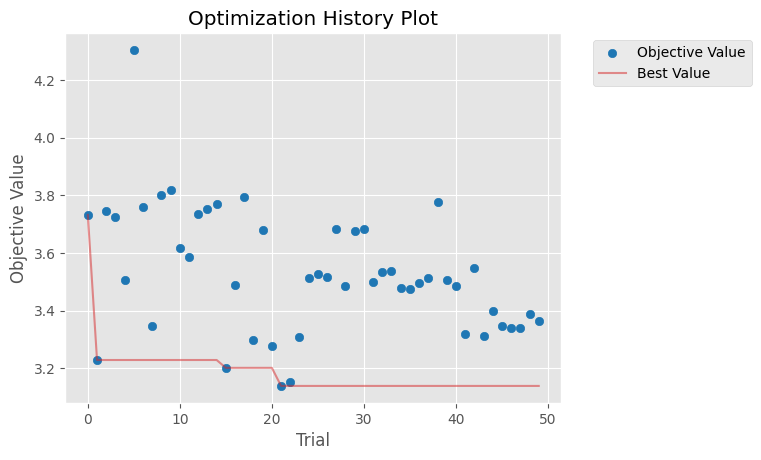

In [42]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study)
